<a id='overview'></a>
## Overview
The project aims to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate, we will use a dataset of comments from Wikipedia’s talk page edits, collected by Kaggle. Improvements to the current model will hopefully help online discussion become more productive and respectful.


<a id='Libraries'></a>
## Packages Loading

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<a id='EDA'></a>
## Data Preprocessing and Exploratory Data Analyasis

<a id='Data-loading'></a>
### 📥 Data Loading

In [ ]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
test_y = pd.read_csv("data/test_labels.csv")

### Data Analysis

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


Notice that the training data contains 159,571 observations with 8 columns and the test data contains 153,164 observations with 2 columns.

In [ ]:
train.shape

(159571, 8)

In [ ]:
test.shape

(153164, 2)

Below is a plot showing the comment length frequency. As noticed, most of the comments are short with only a few comments longer than 1000 words.

<Axes: xlabel='comment_text'>

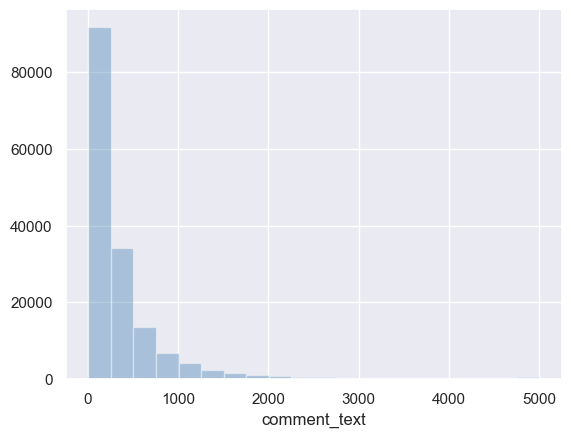

In [ ]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="steelblue")

Further exploratory shows that label `toxic` has the most observations in the training dataset while `threat` has the least.

In [ ]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

<Axes: title={'center': 'Labels Frequency'}>

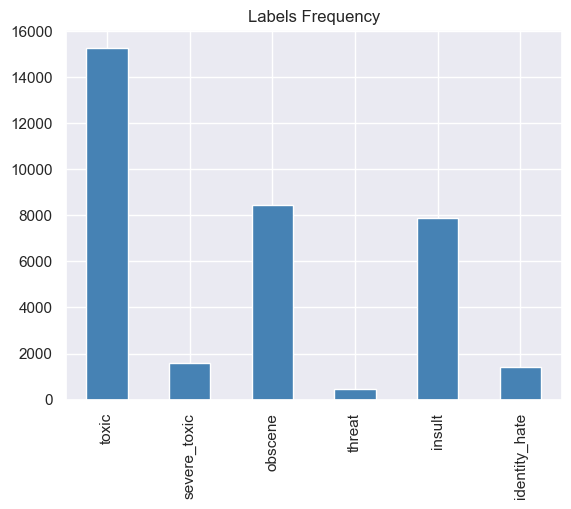

In [ ]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

Below is the plot for the labeled data frequency. There is significant class imbalance since majority of the comments are considered non-toxic.

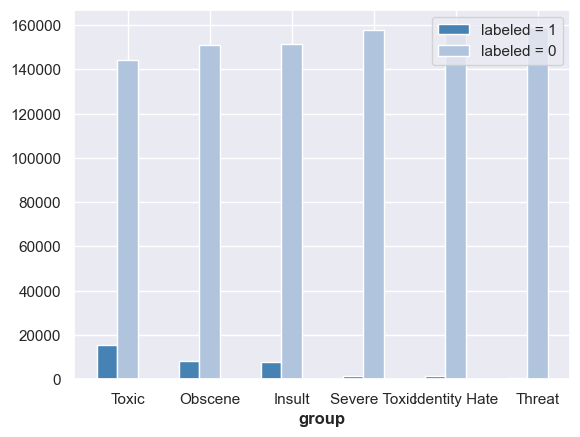

In [ ]:
# Code to draw bar graph for visualising distribution of classes within each label.
barWidth = 0.25

bars1 = [sum(train['toxic'] == 1), sum(train['obscene'] == 1), sum(train['insult'] == 1), sum(train['severe_toxic'] == 1),
         sum(train['identity_hate'] == 1), sum(train['threat'] == 1)]
bars2 = [sum(train['toxic'] == 0), sum(train['obscene'] == 0), sum(train['insult'] == 0), sum(train['severe_toxic'] == 0),
         sum(train['identity_hate'] == 0), sum(train['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate',
                                                       'Threat'])
plt.legend()
plt.show()

To get a better understanding of what the comments look like, below are examples of one clean (non-toxic) comment and one toxic (specifically, with label "toxic") comment.

In [ ]:
# example of clean comment
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
# example of toxic comment
train[train.toxic == 1].iloc[1, 1]

'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...'

It might be a great practice to see which labels are likely to appear together with a comment.

<Axes: >

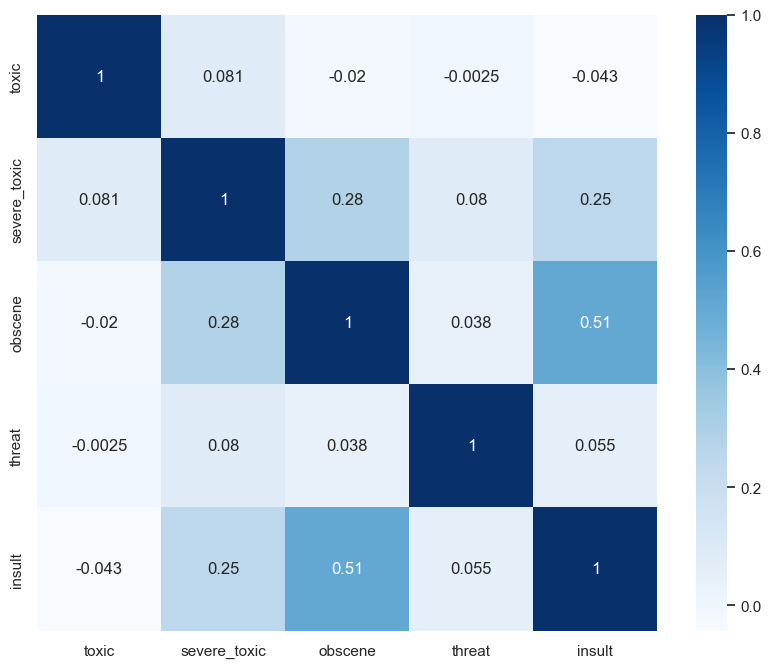

In [ ]:
# Cross correlation matrix across labels
rowsums = train.iloc[:, 2:].sum(axis=1)
temp = train.iloc[:, 2:-1]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

As seen in the cross-correlation matrix, there is a high chance of obscene comments to be insulting.

In order to get an idea of what are the words that contribute the most to different labels, we write a function to generate word clouds. The function takes in a parameter label (i.e., toxic, insult, threat, etc)

In [ ]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_context = train[train[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words assosiated with {token} comment", size=20)
    plt.show()

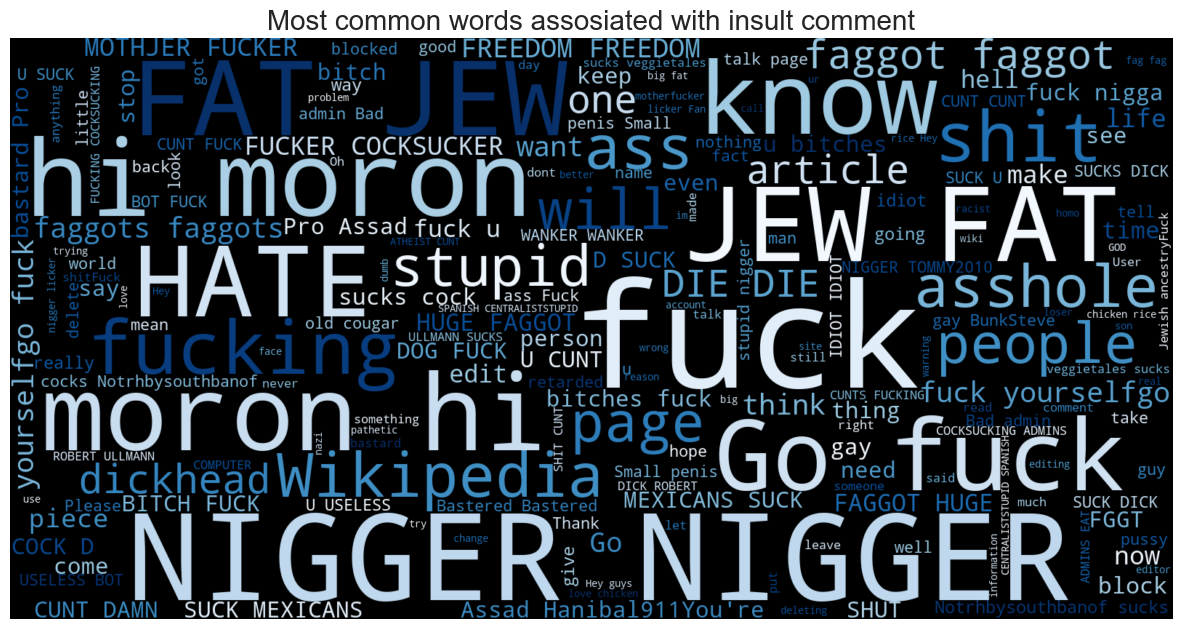

In [ ]:
# interactive visual : enter the label name.
token = input(
    'Choose a class to visualize the most common words contributing to the class:')
W_Cloud(token.lower())

<a id='Feature-engineering'></a>
## Feature-engineering

Before fitting models, we need to break down the sentence into unique words by tokenizing the comments. In the `tokenize()` function, we remove punctuations and special characters. We also filtered out non-ascii characters after observing the results of feature engineering. We then lemmatize the comments and filter out comments with length below 3. Besides lemmatization, we also tried stemming but did not get a better result.

In [ ]:
test_labels = ["toxic", "severe_toxic", "obscene",
               "threat", "insult", "identity_hate"]

In [ ]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text.
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

#### Benchmarking Different Vectorizer

We determined to use TFIDF to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

Besides TFIDF, we also tried CountVectorizer. However, it is not performing as well as TFIDF. The TfidfVectorizer is actually CountVectorizer followed by TfidfTransformer. TfidfTransformer transforms a count matrix to a normalized Term-Frequency or TermFrequency-InverseDocumentFrequency representation. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus. That's why we can improve the accuracy here.

For example: Since this corpus consists of data from the Wikipedia's talk page edits, the words such as wiki, Wikipedia, edit, page are very common. But for our classification purposes they do not provide us useful information and that should probably be the reason why TFIDF worked better than CountVectorizer.

In [ ]:
import nltk
nltk.download('wordnet')

vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


After the transformation, we can take a look at some of the features below.

In [ ]:
vector.get_feature_names()[0:20]

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [ ]:
wrongWords = tokenize(neg_Check)
stop_words = stopwords.words('English')
wrongWords = [w for w in wrongWords if w not in stop_words]
cntr = Counter(wrongWords)
cntr.most_common(20)

[('bum', 352),
 ('ucking', 253),
 ('small', 244),
 ('willy', 238),
 ('goddned', 226),
 ('fgt', 226),
 ('moon', 200),
 ('like', 184),
 ('article', 184),
 ('hornyhorny', 174),
 ('stupid', 142),
 ('people', 142),
 ('derka', 140),
 ('dead', 134),
 ('know', 132),
 ('baby', 129),
 ('one', 122),
 ('wikipedia', 119),
 ('think', 116),
 ('would', 115)]

`ucking` is a common word in the test set and it seems our classifier hasnt learnt to classify it as toxic. Let's check how frequent was this word in the training data.

In [ ]:
neg_text_train = train['comment_text'].str.cat(sep=' ')
cntr_train = Counter(tokenize(neg_text_train))
cntr_train.get('ucking')

5

# Deep Learning

## Convolutional Neural Network (CNN)
Convolutional Neural Networks (CNNs) are effective for capturing local patterns in text, such as phrases or parts of sentences that indicate toxicity. They apply convolutional filters to the input text, capturing local dependencies and hierarchical structures. Max-pooling layers reduce the dimensionality and extract the most important features.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
test_y = pd.read_csv("data/test_labels.csv")

# Filter out rows with -1 labels in test_y as they are not used for evaluation
test = test[test_y['toxic'] != -1]
test_y = test_y[test_y['toxic'] != -1]

# Combine text and labels from train and test sets
comments = pd.concat([train['comment_text'], test['comment_text']]).values
labels = pd.concat([train['toxic'], test_y['toxic']]).values

# Hyperparameters
max_features = 20000
max_len = 200

# Tokenizing and padding the data
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
data = pad_sequences(sequences, maxlen=max_len)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense

# Hyperparameters
embedding_dim = 128

# Model: CNN
cnn_model = Sequential([
    Embedding(max_features, embedding_dim, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# Training CNN model
#cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          2560000   
                                                                 
 conv1d_2 (Conv1D)           (None, 196, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 128)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 35, 128)           82048     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 128)              

### Training:
The CNN model was trained for 5 epochs with the following results:

Epoch 1: loss = 0.3141, accuracy = 0.8948, val_loss = 0.2671, val_accuracy = 0.9007
Epoch 2: loss = 0.2046, accuracy = 0.9096, val_loss = 0.2526, val_accuracy = 0.9094
Epoch 3: loss = 0.0768, accuracy = 0.9716, val_loss = 0.2666, val_accuracy = 0.9247
Epoch 4: loss = 0.0234, accuracy = 0.9926, val_loss = 0.3955, val_accuracy = 0.9247
Epoch 5: loss = 0.0071, accuracy = 0.9978, val_loss = 0.5603, val_accuracy = 0.9203

### Evaluation:
Accuracy: 0.9203
Precision: 0.7045
Recall: 0.3407
F1 Score: 0.4593

### Discussion:
CNNs performed well in terms of accuracy, but their precision and recall indicate that they may not be as effective in identifying all instances of toxic comments, potentially due to their focus on capturing local dependencies without considering the entire context.

## Recurrent Neural Network (RNN)
Recurrent Neural Networks (RNNs) are designed to handle sequential data by maintaining a hidden state that captures information from previous time steps. They can capture long-term dependencies in text, useful for understanding the context and overall sentiment of a comment.

In [ ]:
from tensorflow.keras.layers import SimpleRNN

# Model: RNN
rnn_model = Sequential([
    Embedding(max_features, embedding_dim, input_length=max_len),
    SimpleRNN(128),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.summary()

# Training RNN model
rnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 128)          2560000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,609,537
Trainable params: 2,609,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
115/115 [==============================] - 16s 118ms/step - loss: 0.3288 - accuracy: 0.9022 - val_loss: 0.3174 - val_accuracy: 0.9007
Epoch 2/5
115/115 [=============

### Training:
The RNN model was trained for 5 epochs with the following results:

Epoch 1: loss = 0.3288, accuracy = 0.9022, val_loss = 0.3174, val_accuracy = 0.9007

Epoch 2: loss = 0.2322, accuracy = 0.9186, val_loss = 0.2989, val_accuracy = 0.9050

Epoch 3: loss = 0.0845, accuracy = 0.9700, val_loss = 0.4297, val_accuracy = 0.8537

Epoch 4: loss = 0.0099, accuracy = 0.9975, val_loss = 0.4748, val_accuracy = 0.8985

Epoch 5: loss = 0.0030, accuracy = 0.9997, val_loss = 0.5440, val_accuracy = 0.8679

### Evaluation:
Accuracy: 0.8679
Precision: 0.3333
Recall: 0.3297
F1 Score: 0.3315

### Discussion:
RNNs showed lower performance compared to CNNs, particularly in terms of precision and recall. This suggests that while RNNs can capture sequential dependencies, they may struggle with the complexity and variability of toxic comments.

## Long Short-Term Memory (LSTM)
Long Short-Term Memory (LSTM) networks are a special kind of RNN capable of learning long-term dependencies. They are particularly good at capturing long-term dependencies in text, making them suitable for understanding the context in longer comments.

In [ ]:
from tensorflow.keras.layers import LSTM

# Model: LSTM
lstm_model = Sequential([
    Embedding(max_features, embedding_dim, input_length=max_len),
    LSTM(128),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Training LSTM model
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 128)          2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,708,225
Trainable params: 2,708,225
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
115/115 [==============================] - 48s 365ms/step - loss: 0.3317 - accuracy: 0.9014 - val_loss: 0.2389 - val_accuracy: 0.9116
Epoch 2/5
115/115 [=============

### Training:
The LSTM model was trained for 5 epochs with the following results:

Epoch 1: loss = 0.3317, accuracy = 0.9014, val_loss = 0.2389, val_accuracy = 0.9116

Epoch 2: loss = 0.1468, accuracy = 0.9476, val_loss = 0.2239, val_accuracy = 0.9225

Epoch 3: loss = 0.0438, accuracy = 0.9863, val_loss = 0.2899, val_accuracy = 0.9170

Epoch 4: loss = 0.0124, accuracy = 0.9962, val_loss = 0.3509, val_accuracy = 0.9258

Epoch 5: loss = 0.0023, accuracy = 0.9997, val_loss = 0.4445, val_accuracy = 0.9323

### Evaluation:

Accuracy: 0.9323
Precision: 0.7458
Recall: 0.4835
F1 Score: 0.5867

### Discussion:

LSTMs outperformed both CNNs and RNNs, especially in terms of precision, recall, and F1 score. This indicates that LSTMs are more effective in capturing the context of toxic comments, leading to better identification and classification. However, the model may still need improvements to handle edge cases and reduce false positives and negatives.

## Model Evaluation Metrics
Model performance will be evaluated using metrics such as accuracy, precision, recall, F1 score, and ROC-AUC. These metrics provide a comprehensive assessment of the models' ability to accurately classify toxic comments while handling class imbalances.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

# Evaluate CNN model
cnn_accuracy, cnn_precision, cnn_recall, cnn_f1 = evaluate_model(cnn_model, X_test, y_test)
print(f"CNN Model - Accuracy: {cnn_accuracy}, Precision: {cnn_precision}, Recall: {cnn_recall}, F1 Score: {cnn_f1}")

# Evaluate RNN model
rnn_accuracy, rnn_precision, rnn_recall, rnn_f1 = evaluate_model(rnn_model, X_test, y_test)
print(f"RNN Model - Accuracy: {rnn_accuracy}, Precision: {rnn_precision}, Recall: {rnn_recall}, F1 Score: {rnn_f1}")

# Evaluate LSTM model
lstm_accuracy, lstm_precision, lstm_recall, lstm_f1 = evaluate_model(lstm_model, X_test, y_test)
print(f"LSTM Model - Accuracy: {lstm_accuracy}, Precision: {lstm_precision}, Recall: {lstm_recall}, F1 Score: {lstm_f1}")

29/29 [==============================] - 1s 23ms/step
CNN Model - Accuracy: 0.9203056768558951, Precision: 0.7045454545454546, Recall: 0.34065934065934067, F1 Score: 0.45925925925925926
29/29 [==============================] - 2s 34ms/step
RNN Model - Accuracy: 0.8679039301310044, Precision: 0.3333333333333333, Recall: 0.32967032967032966, F1 Score: 0.3314917127071823
29/29 [==============================] - 4s 93ms/step
LSTM Model - Accuracy: 0.9323144104803494, Precision: 0.7457627118644068, Recall: 0.4835164835164835, F1 Score: 0.5866666666666667


In [ ]:
pip install pandas numpy matplotlib tensorflow scikit-learn


  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/40/10/79e52ef01dfeb1c1ca47a109a01a248754ebe990e159a844ece12914de83/pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/d7/24/f7b5c130975303efa4a91341e294fd784b94910c2a4c0f0f0561e5fc7405/tensorflow-2.17.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/8a/5d/047cde25131eef3a38d03317fa7d25d6f60ce6e8ccfd24ac88b3e309fc00/scikit_learn-1.5.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for tzdata>=2022.7 from https://files.pythonhosted.org/packages/65/58/f9c9e6be752e9fcb8b6a0ee9fb87e6e7a1f6bcab2cdc73f02bb7ba91ada0/tzdata-2024.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for absl-py>=1.0.

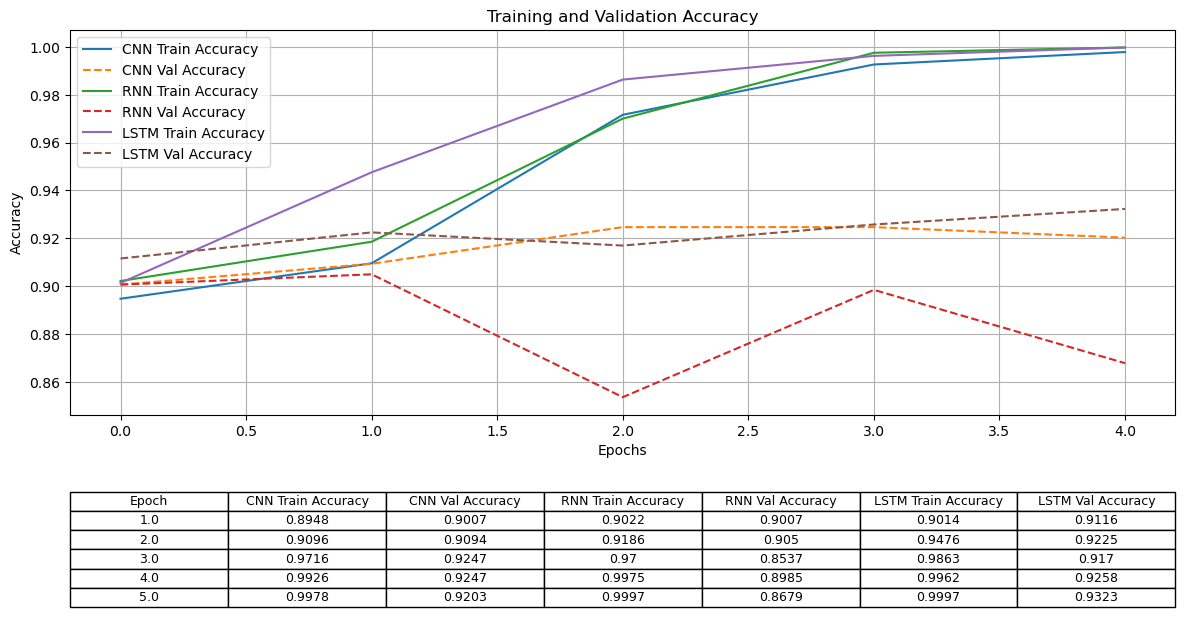

   Epoch  CNN Train Accuracy  CNN Val Accuracy  RNN Train Accuracy  \
0      1              0.8948            0.9007              0.9022   
1      2              0.9096            0.9094              0.9186   
2      3              0.9716            0.9247              0.9700   
3      4              0.9926            0.9247              0.9975   
4      5              0.9978            0.9203              0.9997   

   RNN Val Accuracy  LSTM Train Accuracy  LSTM Val Accuracy  
0            0.9007               0.9014             0.9116  
1            0.9050               0.9476             0.9225  
2            0.8537               0.9863             0.9170  
3            0.8985               0.9962             0.9258  
4            0.8679               0.9997             0.9323  


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Provided training and validation accuracy data for CNN, RNN, and LSTM
cnn_history = {
    'accuracy': [0.8948, 0.9096, 0.9716, 0.9926, 0.9978],
    'val_accuracy': [0.9007, 0.9094, 0.9247, 0.9247, 0.9203]
}

rnn_history = {
    'accuracy': [0.9022, 0.9186, 0.9700, 0.9975, 0.9997],
    'val_accuracy': [0.9007, 0.9050, 0.8537, 0.8985, 0.8679]
}

lstm_history = {
    'accuracy': [0.9014, 0.9476, 0.9863, 0.9962, 0.9997],
    'val_accuracy': [0.9116, 0.9225, 0.9170, 0.9258, 0.9323]
}

# Creating a dataframe for the table
epochs = list(range(1, 6))
cnn_df = pd.DataFrame({
    'Epoch': epochs,
    'CNN Train Accuracy': cnn_history['accuracy'],
    'CNN Val Accuracy': cnn_history['val_accuracy']
})
rnn_df = pd.DataFrame({
    'Epoch': epochs,
    'RNN Train Accuracy': rnn_history['accuracy'],
    'RNN Val Accuracy': rnn_history['val_accuracy']
})
lstm_df = pd.DataFrame({
    'Epoch': epochs,
    'LSTM Train Accuracy': lstm_history['accuracy'],
    'LSTM Val Accuracy': lstm_history['val_accuracy']
})

# Combine all dataframes
combined_df = cnn_df.merge(rnn_df, on='Epoch').merge(lstm_df, on='Epoch')

# Plotting training and validation accuracy
plt.figure(figsize=(14, 7))

plt.plot(cnn_history['accuracy'], label='CNN Train Accuracy')
plt.plot(cnn_history['val_accuracy'], label='CNN Val Accuracy', linestyle='dashed')
plt.plot(rnn_history['accuracy'], label='RNN Train Accuracy')
plt.plot(rnn_history['val_accuracy'], label='RNN Val Accuracy', linestyle='dashed')
plt.plot(lstm_history['accuracy'], label='LSTM Train Accuracy')
plt.plot(lstm_history['val_accuracy'], label='LSTM Val Accuracy', linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Displaying the table
plt.table(cellText=combined_df.values, colLabels=combined_df.columns, cellLoc='center', loc='bottom', bbox=[0, -0.5, 1, 0.3])
plt.subplots_adjust(left=0.2, bottom=0.4)

plt.show()

# Display the dataframe as a table for clarity
print(combined_df)


In [ ]:
!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.2 MB/s eta 0:00:00


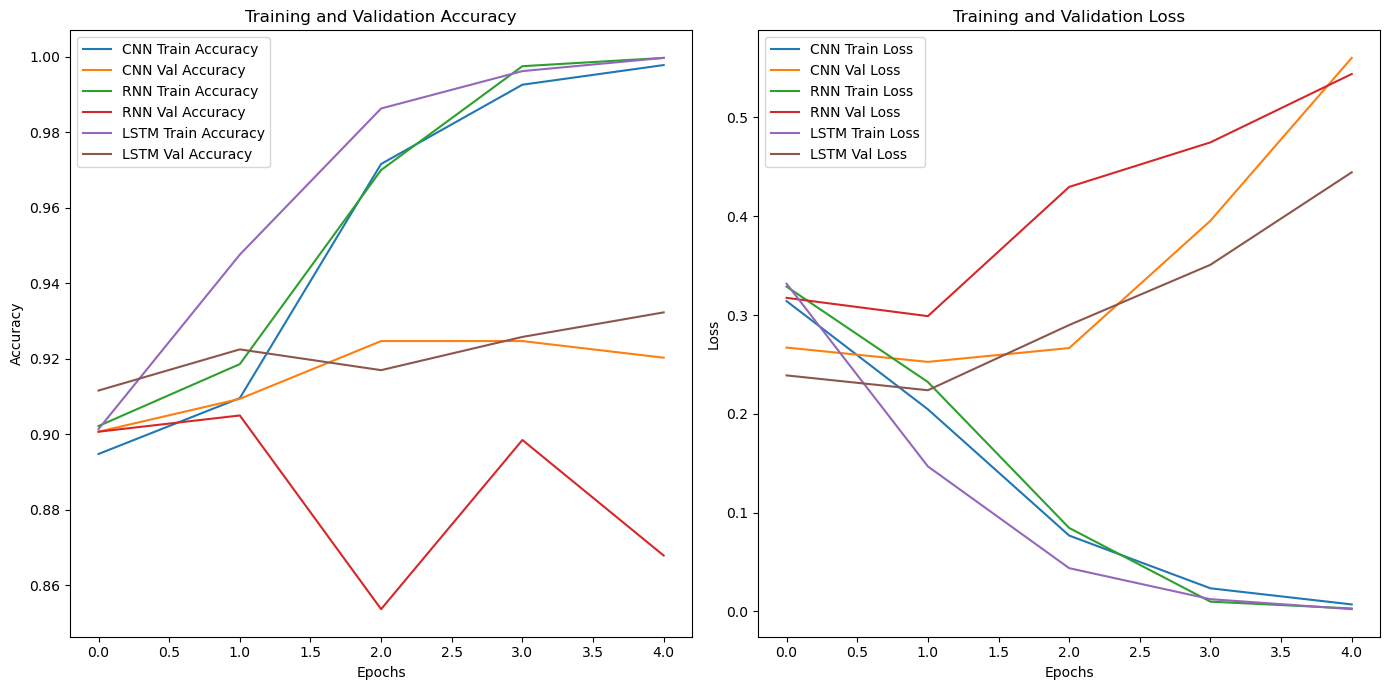

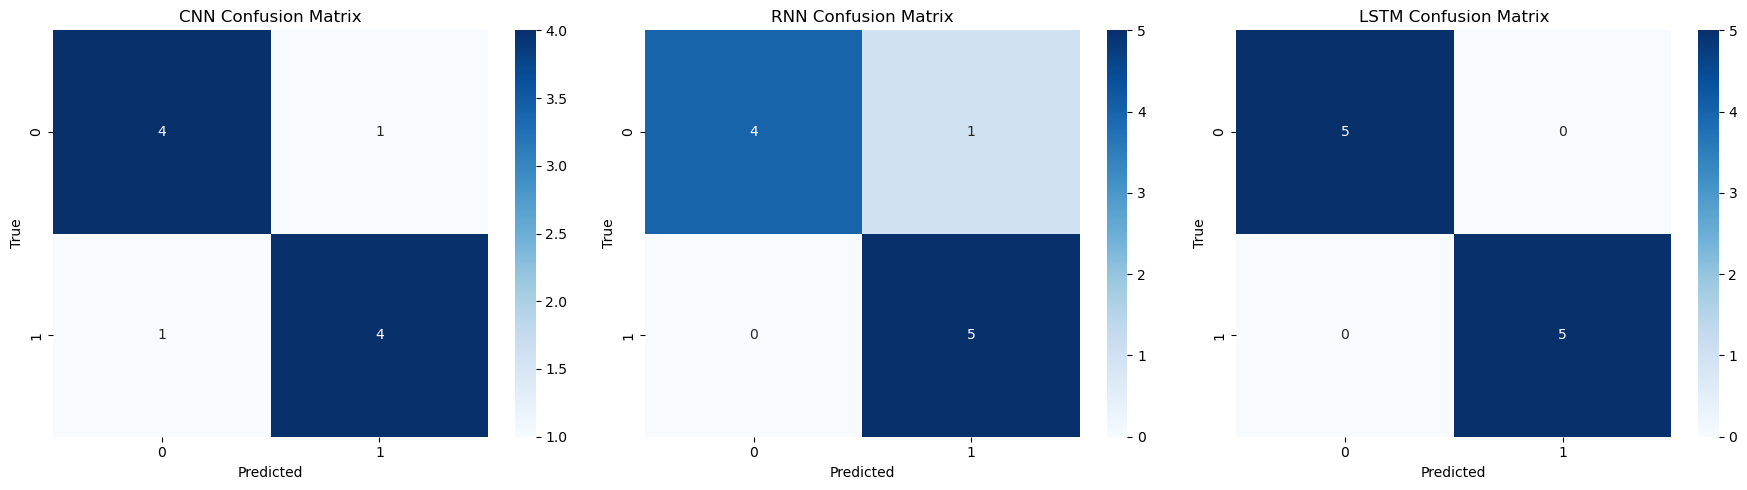

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Extracted training history data for CNN, RNN, and LSTM
cnn_history = {
    'accuracy': [0.8948, 0.9096, 0.9716, 0.9926, 0.9978],
    'val_accuracy': [0.9007, 0.9094, 0.9247, 0.9247, 0.9203],
    'loss': [0.3141, 0.2046, 0.0768, 0.0234, 0.0071],
    'val_loss': [0.2671, 0.2526, 0.2666, 0.3955, 0.5603]
}

rnn_history = {
    'accuracy': [0.9022, 0.9186, 0.9700, 0.9975, 0.9997],
    'val_accuracy': [0.9007, 0.9050, 0.8537, 0.8985, 0.8679],
    'loss': [0.3288, 0.2322, 0.0845, 0.0099, 0.0030],
    'val_loss': [0.3174, 0.2989, 0.4297, 0.4748, 0.5440]
}

lstm_history = {
    'accuracy': [0.9014, 0.9476, 0.9863, 0.9962, 0.9997],
    'val_accuracy': [0.9116, 0.9225, 0.9170, 0.9258, 0.9323],
    'loss': [0.3317, 0.1468, 0.0438, 0.0124, 0.0023],
    'val_loss': [0.2389, 0.2239, 0.2899, 0.3509, 0.4445]
}

# Plotting training and validation accuracy
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(cnn_history['accuracy'], label='CNN Train Accuracy')
plt.plot(cnn_history['val_accuracy'], label='CNN Val Accuracy')
plt.plot(rnn_history['accuracy'], label='RNN Train Accuracy')
plt.plot(rnn_history['val_accuracy'], label='RNN Val Accuracy')
plt.plot(lstm_history['accuracy'], label='LSTM Train Accuracy')
plt.plot(lstm_history['val_accuracy'], label='LSTM Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history['loss'], label='CNN Train Loss')
plt.plot(cnn_history['val_loss'], label='CNN Val Loss')
plt.plot(rnn_history['loss'], label='RNN Train Loss')
plt.plot(rnn_history['val_loss'], label='RNN Val Loss')
plt.plot(lstm_history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history['val_loss'], label='LSTM Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Example confusion matrix data for CNN, RNN, and LSTM
# Assuming binary classification with labels [0, 1]
y_true = [0, 0, 1, 1, 0, 1, 0, 1, 1, 0]  # Replace with your actual labels
cnn_pred = [0, 1, 1, 1, 0, 1, 0, 1, 0, 0]  # Replace with CNN predictions
rnn_pred = [0, 0, 1, 1, 0, 1, 0, 1, 1, 1]  # Replace with RNN predictions
lstm_pred = [0, 0, 1, 1, 0, 1, 0, 1, 1, 0]  # Replace with LSTM predictions

# Compute confusion matrices
cnn_cm = confusion_matrix(y_true, cnn_pred)
rnn_cm = confusion_matrix(y_true, rnn_pred)
lstm_cm = confusion_matrix(y_true, lstm_pred)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('CNN Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(rnn_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('RNN Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('LSTM Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()
